In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import util
from util import Camera
from util_gau import load_ply, naive_gaussian


In [123]:
gaussians = naive_gaussian()
g_width, g_height = 1280, 720
scale_modifier = 1.0

class Gaussian:
    def __init__(self, pos, scale, rot, opacity):
        self.pos = np.array(pos)
        self.scale = np.array(scale_modifier * scale)
        # Initialize scipy Quaternion from rot (s, x, y, z)
        self.rot = sp.spatial.transform.Rotation.from_quat([rot[1], rot[2], rot[3], rot[0]])
        self.opacity = opacity[0]
        self.cov3D = self.compute_cov3d()

    def compute_cov3d(self):
        cov3D = np.diag(self.scale**2)
        cov3D = self.rot.as_matrix().T @ cov3D @ self.rot.as_matrix()
        return cov3D

    def get_pos_cam(self, view_matrix):
        return camera.world_to_cam(self.pos)

    def get_cov2d(self, camera):
        pos_cam = self.get_pos_cam(camera.get_view_matrix())
        view_matrix = camera.get_view_matrix()
        [htan_fovx, htan_fovy, focal] = camera.get_htanfovxy_focal()
        focal_x = focal_y = focal

        t = np.copy(pos_cam)

        limx = 1.3 * htan_fovx
        limy = 1.3 * htan_fovy
        txtz = t[0]/t[2]
        tytz = t[1]/t[2]

        tx = min(limx, max(-limx, txtz)) * t[2]
        ty = min(limy, max(-limx, tytz)) * t[2]
        tz= t[2]

        J = np.array([
            [focal_x/tz, 0.0, -(focal_x * tx)/(tz * tz)],
            [0.0, focal_y/tz, -(focal_y * ty)/(tz * tz)],
            [0.0, 0.0, 0.0]
        ])
        W = view_matrix[:3, :3].T
        T = W @ J
        cov = T.T @ self.cov3D.T @ T

        cov[0,0] += 0.3
        cov[1,1] += 0.3
        return cov[:2, :2], pos_cam

    def get_conic_and_bb(self, camera):
        cov2d, pos_cam = self.get_cov2d(camera)
        det = np.linalg.det(cov2d)
        if det == 0.0:
            return None

        det_inv = 1.0 / det
        cov = [cov2d[0,0], cov2d[0,1], cov2d[1,1]]
        conic = np.array([cov[2] * det_inv, -2*cov[1] * det_inv, cov[0] * det_inv])

        # compute 3-sigma bounding box
        [htanx, htany, focal] = camera.get_htanfovxy_focal()

        quadwh_scr = np.array([3.0 * np.sqrt(cov[0]), 3.0 * np.sqrt(cov[2])])
        wh = 2 * np.array([htanx, htany]) * focal
        quadwh_ndc = np.divide(quadwh_scr, wh) * 2

        vertices = np.array([[-1, 1], [1, 1], [1, -1], [-1, -1]])
        # Four coordxy values
        # Elementwise multiplication of each row with quadwh_scr
        coordxy = np.multiply(vertices, quadwh_scr)

        # compute g_pos_screen and gl_position
        view_matrix = camera.get_view_matrix()
        projection_matrix = camera.get_projection_matrix()

        position4 = np.append(self.pos, 1.0)
        g_pos_view = view_matrix @ position4
        g_pos_screen = projection_matrix @ g_pos_view
        g_pos_screen = g_pos_screen / g_pos_screen[3]
        
        gl_position = np.multiply(vertices, quadwh_ndc) + g_pos_screen[:2]
        gl_position = np.hstack((gl_position, np.zeros((vertices.shape[0],2))))
        gl_position[:,2:4] = g_pos_screen[2:4]
        
        g_pos_quad = np.divide(g_pos_screen[:2], wh) * 2.0 
        depth = g_pos_screen[2]
        return conic, depth, coordxy, gl_position

# Iterate over the gaussians and create Gaussian objects
gaussian_objects = []
for (pos, scale, rot, opacity) in zip(gaussians.xyz, gaussians.scale, gaussians.rot, gaussians.opacity):
    gau = Gaussian(pos, scale, rot, opacity)
    gaussian_objects.append(gau)


In [124]:
# Force re-load Camera python module
import importlib
import util

importlib.reload(util)

camera = util.Camera(g_height, g_width)
# print(gaussian_objects[1].cov3D, gaussian_objects[1].pos)
conics_and_bbs = [gau.get_conic_and_bb(camera) for gau in gaussian_objects]
print(conics_and_bbs[0][-1])

[[-0.01706919  0.03034524  0.9935327   1.        ]
 [ 0.01706919  0.03034524  0.9935327   1.        ]
 [ 0.01706919 -0.03034524  0.9935327   1.        ]
 [-0.01706919 -0.03034524  0.9935327   1.        ]]


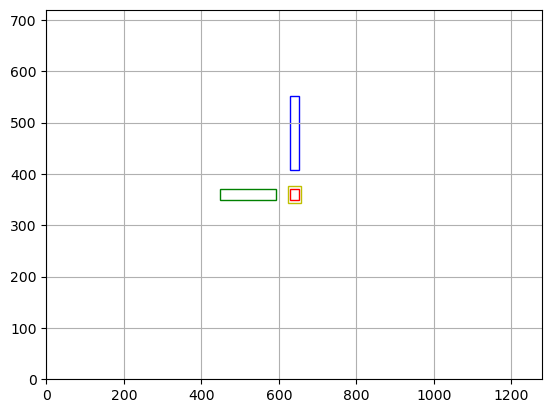

In [137]:
# Plot conic using equation A*x**2 + B*x*y + C*y**2 = 1
# where A, B, C are the conic parameters

# plot the boundary where the equation is satisfied


# Get gaussian indices sorted by depth (pos_screen[2])
indices = np.argsort([depth for conic, depth, _, _ in conics_and_bbs])

def plot_conics_and_bbs(conics_and_bbs, camera):
    # convert to NDC
    x_cam, y_cam = np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)
    X_cam, Y_cam = np.meshgrid(x_cam, y_cam)

    ax = plt.gca()
    colors = ['r', 'g', 'b', 'y', 'm', 'c']

    for i,(conic, depth, coordxy, gl_position) in enumerate(conics_and_bbs):
        if conic is None:
            continue

        A, B, C = conic

        # coordxy is the correct scale to be used with gaussian
        x_cam = np.linspace(coordxy[0][0], coordxy[1][0], 100)
        y_cam = np.linspace(coordxy[1][0], coordxy[1][1], 100)
        X, Y = np.meshgrid(x_cam, y_cam)
        
        # 3-sigma ellipse
        F = A*X**2 + 2*B*X*Y + C*Y**2 - 1.0
        XY_px = np.vstack([x_cam, y_cam])
        # scale by w and h and offset to convert to pixel coordinates
        XY_px[0] = XY_px[0] * camera.w / 2 + camera.w / 2
        XY_px[1] = -XY_px[1] * camera.h / 2 + camera.h / 2
        X_px_flat = XY_px[0]
        Y_px_flat = XY_px[1]
        X_px, Y_px = np.meshgrid(X_px_flat, Y_px_flat)

        F_val = 0.0
        plt.contour(X_px, Y_px, F, [F_val], colors=colors[i])

        # Plot a rectangle around the gaussian position based on bb
        bbox_screen = camera.ndc_to_pixel(gl_position)
        
        ul = bbox_screen[0,:2]
        ur = bbox_screen[1,:2]
        lr = bbox_screen[2,:2]
        ll = bbox_screen[3,:2]
        ax.add_patch(plt.Rectangle((ul[0], ul[1]), ur[0] - ul[0], lr[1] - ur[1], fill=False, color=colors[i]))

fig = plt.figure()
ax = plt.gca()
plot_conics_and_bbs(conics_and_bbs, camera)
plt.xlim([0, camera.w])
plt.ylim([0, camera.h])
plt.grid(True)
plt.show()


In [142]:
print(list(range(1,4)))
print(np.linspace(0,1,4-1))

[1, 2, 3]
[0.  0.5 1. ]


34 32
22 20
146 20
22 144


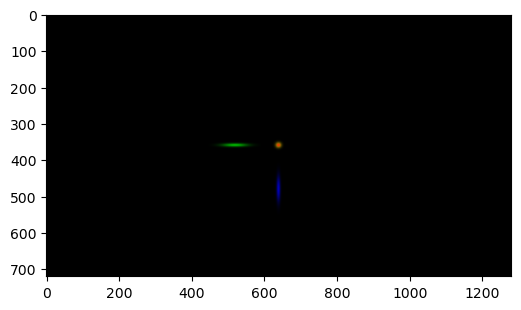

In [156]:
import importlib
import util

importlib.reload(util)

camera = util.Camera(g_height, g_width)
# print(gaussian_objects[1].cov3D, gaussian_objects[1].pos)
conics_and_bbs = [gau.get_conic_and_bb(camera) for gau in gaussian_objects]


def plot_opacity(gaussian: Gaussian, camera: Camera, color: (int, int, int), w: int, h: int, bitmap: np.ndarray, alphas: np.ndarray):
    # Compute the opacity of a gaussian given the camera
    conic, depth, coordxy, gl_position = gaussian.get_conic_and_bb(camera)

    A, B, C = conic

    bbox_screen = camera.ndc_to_pixel(gl_position)

    ul = bbox_screen[0,:2]
    ur = bbox_screen[1,:2]
    lr = bbox_screen[2,:2]
    ll = bbox_screen[3,:2]
    
    y1 = int(np.floor(ll[1]))
    y2 = int(np.ceil(ul[1]))
    
    x1 = int(np.floor(ul[0]))
    x2 = int(np.ceil(ur[0]))
    nx = abs(x2 - x1)
    ny = abs(y1 - y2)

    # Extract out inputs for the gaussian
    x_cam_1 = coordxy[0][0]   # ul
    x_cam_2 = coordxy[1][0]   # ur
    y_cam_1 = coordxy[1][1]   # ur (y)
    y_cam_2 = coordxy[2][1]   # lr

    print(nx, ny)
    for x, x_cam in zip(range(x1, x2), np.linspace(x_cam_1, x_cam_2, nx)):
        for y, y_cam in zip(range(y2, y1), np.linspace(y_cam_1, y_cam_2, ny)):
            if x < 0 or x >= w or y < 0 or y >= h:
                continue

            # Gaussian is typically calculated as f(x, y) = A * exp(-(a*x^2 + 2*b*x*y + c*y^2))
            power = -(A*x_cam**2 + C*y_cam**2)/2.0 - B * x_cam * y_cam
            if power > 0.0:
                continue

            opacity = gaussian.opacity * np.exp(power)
            opacity = min(0.99, opacity)
            if opacity < 1.0 / 255.0:
                continue

            # Set the pixel color to the given color and opacity
            # Do alpha blending using "over" method
            alpha = opacity*0.75
            old_alpha = alphas[y, x]
            new_alpha = alpha + old_alpha * (1.0 - alpha)

            alphas[y, x] = new_alpha
            bitmap[y, x, :] = (color[0:3]) * alpha + bitmap[y, x, :] * (1.0 - alpha)



# Initialize a bitmap with alpha channel of size w x h
(h, w) = (720, 1280)
bitmap = np.zeros((h, w, 3), np.float32)
alphas = np.zeros((h, w))

plt.figure(figsize=(6,6))
colors = np.array([(1.0, 0, 0), (0, 1.0, 0), (0, 0, 1.0), (1.0, 1.0, 0), (1.0, 0, 1.0), (0, 1.0, 1.0)])
for idx in indices[0:4]:
    plot_opacity(gaussian_objects[idx], camera, colors[idx], w, h, bitmap, alphas)

# Plot the bitmap
plt.imshow(bitmap, alpha=alphas, interpolation='bilinear', vmin=0, vmax=1.0)

plt.show()


In [6]:
camera = Camera(g_height, g_width)
camera.get_view_matrix()

array([[-1., -0., -0.,  0.],
       [ 0., -1.,  0., -0.],
       [-0., -0.,  1., -3.],
       [ 0.,  0.,  0.,  1.]])

In [7]:
camera.get_projection_matrix()

array([[ 0.5625  ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  1.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      , -1.0002  , -0.020002],
       [ 0.      ,  0.      , -1.      ,  0.      ]], dtype=float32)

In [9]:
gaussian_objects[0].pos

array([0., 0., 0.], dtype=float32)

In [10]:
camera.get_htanfovxy_focal()

[1.777777777777778, 1.0, 360.0]

In [11]:
camera.position

array([0., 0., 3.])

In [12]:
indices

array([0, 1, 2, 3])